In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime

# Load the data
data = pd.read_csv('DATASET7k.csv')

# Drop the columns that are not required
data = data.drop(['OpenInt'], axis=1)

# Convert date strings to Unix timestamps
data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').timestamp())

# Split the data into training and testing sets with 80% for training and 20% for testing
train_data = data[:int(0.8*len(data))]
test_data = data[int(0.8*len(data)):]
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Split the data into features and labels
train_features = train_data.drop(['Close'], axis=1)
train_labels = train_data['Close']
train_labels = train_labels.astype('float32')
test_features = test_data.drop(['Close'], axis=1)
test_labels = test_data['Close']
test_labels = test_labels.astype('float32')

# Normalize the feature between 0 and 1
train_features = (train_features - train_features.min()) / (train_features.max() - train_features.min())
test_features = (test_features - test_features.min()) / (test_features.max() - test_features.min())

# Normalize the labels between 0 and 1
train_labels = (train_labels - train_labels.min()) / (train_labels.max() - train_labels.min())
test_labels = (test_labels - test_labels.min()) / (test_labels.max() - test_labels.min())


# Print the shapes of the training and testing sets
print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

# Create train and test TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(10000).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(128)

# Define the DBN model architecture
class DBN(tf.keras.Model):
    def __init__(self, units, num_classes):
        super(DBN, self).__init__()
        self.units = units
        self.num_classes = num_classes
        self.dense_stack = [tf.keras.layers.Dense(unit, activation='relu') for unit in units]
        self.logits = tf.keras.layers.Dense(num_classes)

    def call(self, inputs):
        x = inputs
        for dense in self.dense_stack:
            x = dense(x)
        return self.logits(x)
    
# Define the loss function
def loss(model, x, y):
    y_ = model(x)
    return tf.keras.losses.MSE(y, y_)

# Define the gradient function
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define the accuracy metric
def accuracy(model, x, y):
    y_ = model(x)
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Define the number of units in each layer
units = [64, 64, 64]

# Define the number of classes
num_classes = 1

# Build the model
dbn_model = DBN(units, num_classes)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define the number of epochs
num_epochs = 30

# Define the lists to store the loss and accuracy values
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []

# Train the model
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.MeanAbsoluteError()
    test_epoch_loss_avg = tf.keras.metrics.Mean()
    test_epoch_accuracy = tf.keras.metrics.MeanAbsoluteError()
    
    # Training loop
    for x, y in train_dataset:
        loss_value, grads = grad(dbn_model, x, y)
        optimizer.apply_gradients(zip(grads, dbn_model.trainable_variables))
        epoch_loss_avg(loss_value)
        epoch_accuracy(y, dbn_model(x))
        
    # Testing loop
    for x, y in test_dataset:
        test_loss_value = loss(dbn_model, x, y)
        test_epoch_loss_avg(test_loss_value)
        test_epoch_accuracy(y, dbn_model(x))
        
    # Store the loss and accuracy values in lists
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    test_loss_results.append(test_epoch_loss_avg.result())
    test_accuracy_results.append(test_epoch_accuracy.result())
    
    # Print the loss and accuracy values for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}, Test Loss: {:.3f}, Test Accuracy: {:.3%}".format(epoch + 1, epoch_loss_avg.result(), epoch_accuracy.result(), test_epoch_loss_avg.result(), test_epoch_accuracy.result()))

# Print the loss and accuracy values for every epoch
for epoch in range(num_epochs):
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}, Test Loss: {:.3f}, Test Accuracy: {:.3%}".format(epoch + 1, train_loss_results[epoch], train_accuracy_results[epoch], test_loss_results[epoch], test_accuracy_results[epoch]))




(5823, 5) (5823,)
(1456, 5) (1456,)
Epoch 010: Loss: 0.034, Accuracy: 15.046%, Test Loss: 0.062, Test Accuracy: 21.520%
Epoch 020: Loss: 0.034, Accuracy: 15.043%, Test Loss: 0.070, Test Accuracy: 22.722%
Epoch 030: Loss: 0.034, Accuracy: 15.094%, Test Loss: 0.061, Test Accuracy: 21.185%
Epoch 001: Loss: 0.065, Accuracy: 12.101%, Test Loss: 0.032, Test Accuracy: 15.386%
Epoch 002: Loss: 0.035, Accuracy: 14.150%, Test Loss: 0.053, Test Accuracy: 20.246%
Epoch 003: Loss: 0.034, Accuracy: 14.868%, Test Loss: 0.057, Test Accuracy: 20.781%
Epoch 004: Loss: 0.034, Accuracy: 14.994%, Test Loss: 0.056, Test Accuracy: 20.408%
Epoch 005: Loss: 0.034, Accuracy: 15.006%, Test Loss: 0.064, Test Accuracy: 21.900%
Epoch 006: Loss: 0.034, Accuracy: 15.042%, Test Loss: 0.068, Test Accuracy: 22.551%
Epoch 007: Loss: 0.034, Accuracy: 15.009%, Test Loss: 0.059, Test Accuracy: 20.880%
Epoch 008: Loss: 0.034, Accuracy: 15.023%, Test Loss: 0.064, Test Accuracy: 21.941%
Epoch 009: Loss: 0.034, Accuracy: 14.948

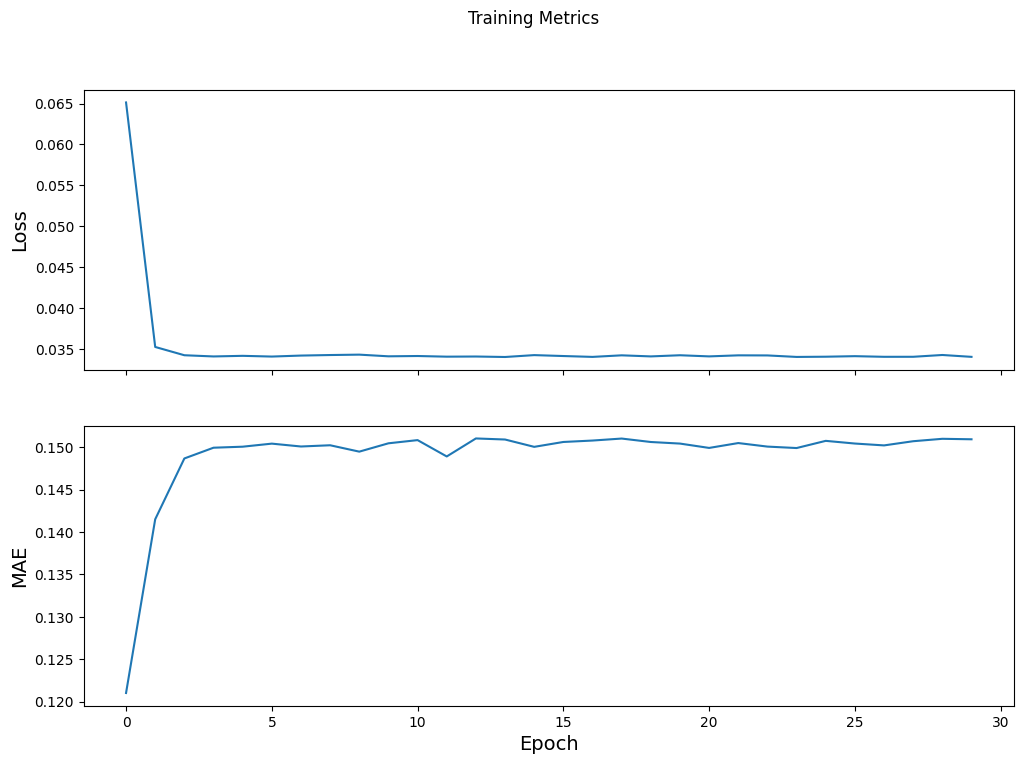

In [3]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy values
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("MAE", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

46/46 [==============================] - 0s 2ms/step


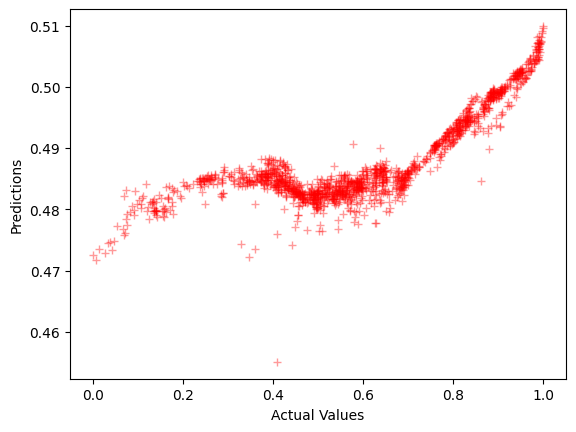

Model: "dbn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  384       
                                                                 
 dense_5 (Dense)             multiple                  4160      
                                                                 
 dense_6 (Dense)             multiple                  4160      
                                                                 
 dense_7 (Dense)             multiple                  65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Convert test_labels to numpy array if it's a tuple
if isinstance(test_labels, tuple):
    test_labels = np.asarray(test_labels)
    
# Convert test_features to numpy array if it's a tuple
if isinstance(test_features, tuple):
    test_features = np.asarray(test_features)

# Plot predictions against actual values without a scatter plot
test_predictions = dbn_model.predict(test_features)
plt.plot(test_labels, test_predictions, 'r+', alpha=0.4)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.show()

# Print the model summary
dbn_model.summary()
